RandAugment: Practical automated data augmentation with a reduced search space - [pdf](https://arxiv.org/pdf/1909.13719.pdf)
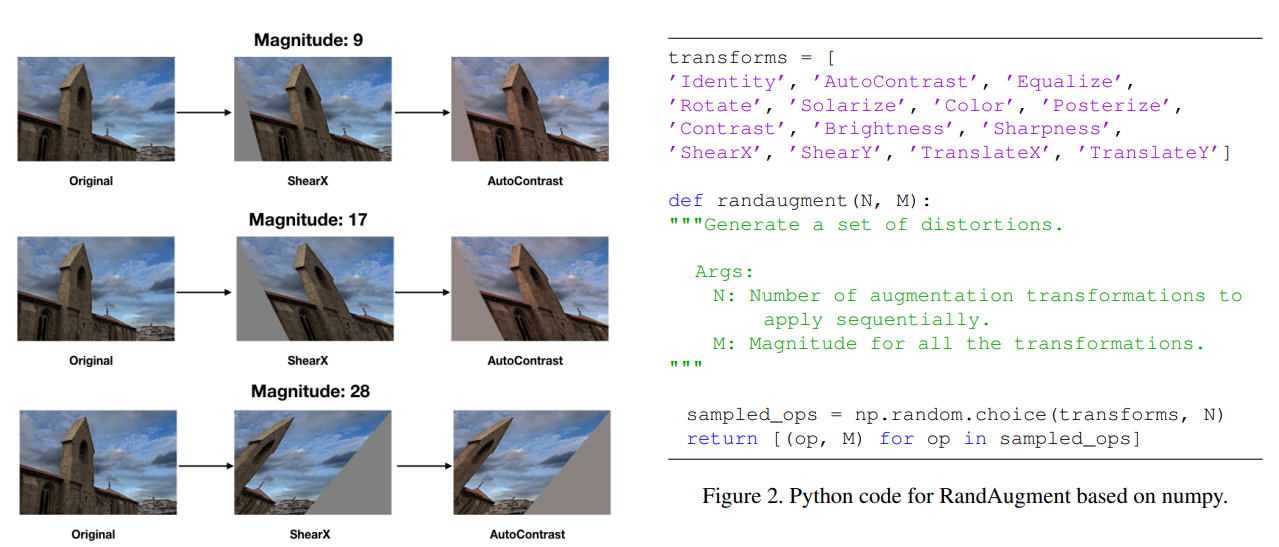

# 준비

## 라이브러리 및 세팅

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from imgaug import augmenters as iaa
import imgaug as ia

tfds.disable_progress_bar()
tf.random.set_seed(42)
ia.seed(42)

## 데이터

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")

Total training examples: 50000
Total test examples: 10000


## 하이퍼 파라미터

In [16]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 128
EPOCHS = 30
IMAGE_SIZE = 72

## 데이터 셋

In [17]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BATCH_SIZE * 100).batch(BATCH_SIZE).map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO,
    ).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO,
    ).prefetch(AUTO)

## 데이터 셋 샘플

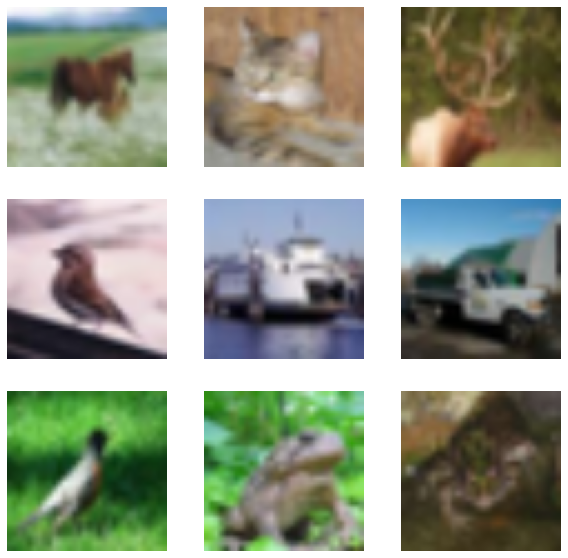

In [18]:
sample_images, _ = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

# 증강

## Random Aug

In [19]:
rand_aug = iaa.RandAugment(n=3, m=7)

def augment(images):
    images = tf.cast(images, tf.uint8)
    return rand_aug(images=images.numpy())

In [20]:
train_ds_rand = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BATCH_SIZE * 100).batch(BATCH_SIZE).map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO,
    ).map(
        lambda x, y: (tf.py_function(augment, [x], [tf.float32])[0], y),
        num_parallel_calls=AUTO,
    ).prefetch(AUTO))

### Random Aug 샘플

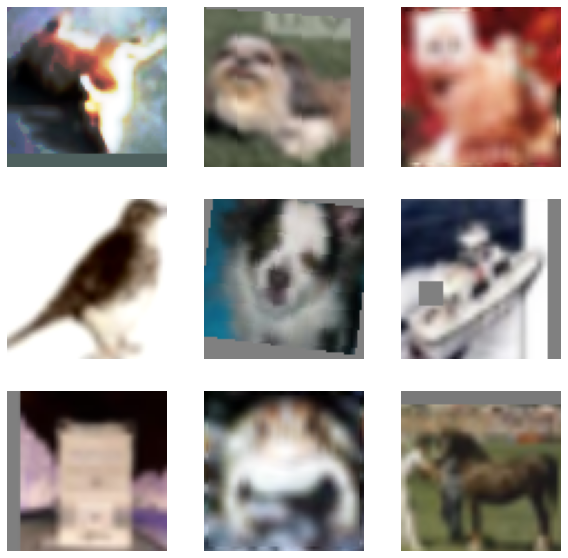

In [21]:
sample_images, _ = next(iter(train_ds_rand))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

## Simple Aug

In [22]:
simple_aug = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(factor=0.02),
    layers.RandomZoom(height_factor=0.2, width_factor=0.2),
])

# Now, map the augmentation pipeline to our training dataset
train_ds_simple = (tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(BATCH_SIZE * 100).batch(BATCH_SIZE).map(
        lambda x, y: (simple_aug(x), y),
        num_parallel_calls=AUTO).prefetch(AUTO))

### Simple Aug 샘플

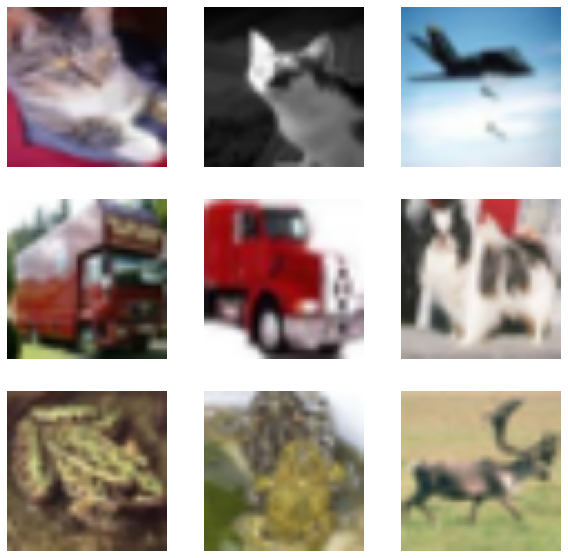

In [23]:
sample_images, _ = next(iter(train_ds_simple))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

# 훈련

## initial_model

In [24]:
def get_training_model():
    resnet50_v2 = tf.keras.applications.ResNet50V2(
        weights=None,
        include_top=True,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        classes=10,
    )
    model = tf.keras.Sequential(
        [
            layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
            layers.Rescaling(scale=1.0 / 127.5, offset=-1),
            resnet50_v2,
        ]
    )
    return model

get_training_model().summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 72, 72, 3)         0         
                                                                 
 resnet50v2 (Functional)     (None, 10)                23585290  
                                                                 
Total params: 23,585,290
Trainable params: 23,539,850
Non-trainable params: 45,440
_________________________________________________________________


In [25]:
initial_model = get_training_model()
initial_model.save_weights("model/initial_weights.h5")

## Random Aug model

In [26]:
rand_aug_model = get_training_model()
rand_aug_model.load_weights("model/initial_weights.h5")
rand_aug_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
rand_aug_model.fit(train_ds_rand, validation_data=test_ds, epochs=EPOCHS)
_, test_acc = rand_aug_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/30
391/391 [==============================] - 68s 150ms/step - loss: 1.7871 - accuracy: 0.3547 - val_loss: 2.0735 - val_accuracy: 0.3939
Epoch 2/30
391/391 [==============================] - 58s 146ms/step - loss: 1.3681 - accuracy: 0.5126 - val_loss: 1.5081 - val_accuracy: 0.5019
Epoch 3/30
391/391 [==============================] - 58s 148ms/step - loss: 1.1377 - accuracy: 0.6017 - val_loss: 1.9007 - val_accuracy: 0.5491
Epoch 4/30
391/391 [==============================] - 59s 148ms/step - loss: 1.0031 - accuracy: 0.6508 - val_loss: 0.8589 - val_accuracy: 0.7068
Epoch 5/30
391/391 [==============================] - 58s 145ms/step - loss: 0.9024 - accuracy: 0.6859 - val_loss: 0.8446 - val_accuracy: 0.7155
Epoch 6/30
391/391 [==============================] - 59s 148ms/step - loss: 0.8348 - accuracy: 0.7118 - val_loss: 0.6936 - val_accuracy: 0.7620
Epoch 7/30
391/391 [==============================] - 60s 152ms/step - loss: 0.7826 - accuracy: 0.7289 - val_loss: 0.7527 - val_ac

## Simple Aug model

In [27]:
simple_aug_model = get_training_model()
simple_aug_model.load_weights("model/initial_weights.h5")
simple_aug_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
simple_aug_model.fit(train_ds_simple, validation_data=test_ds, epochs=EPOCHS)
_, test_acc = simple_aug_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/30
391/391 [==============================] - 56s 134ms/step - loss: 1.3814 - accuracy: 0.5031 - val_loss: 1.7171 - val_accuracy: 0.4753
Epoch 2/30
391/391 [==============================] - 52s 133ms/step - loss: 0.9584 - accuracy: 0.6604 - val_loss: 1.1636 - val_accuracy: 0.6285
Epoch 3/30
391/391 [==============================] - 52s 133ms/step - loss: 0.7337 - accuracy: 0.7427 - val_loss: 1.0321 - val_accuracy: 0.6861
Epoch 4/30
391/391 [==============================] - 52s 133ms/step - loss: 0.5733 - accuracy: 0.7988 - val_loss: 1.2456 - val_accuracy: 0.6581
Epoch 5/30
391/391 [==============================] - 52s 133ms/step - loss: 0.4618 - accuracy: 0.8397 - val_loss: 0.7769 - val_accuracy: 0.7562
Epoch 6/30
391/391 [==============================] - 52s 133ms/step - loss: 0.3665 - accuracy: 0.8723 - val_loss: 0.8651 - val_accuracy: 0.7423
Epoch 7/30
391/391 [==============================] - 52s 133ms/step - loss: 0.2830 - accuracy: 0.8988 - val_loss: 0.7822 - val_ac

# 평가

* Randam_augmentation을 사용했을 때 과대 적합이 되는 것을 방지하고 일반화 성능을 올려 최종 val_acc 의 값이 0.08 까지 차이가는 것을 확인할 수 있었다.